In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import fiona
import seaborn as sns
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show, show_hist
from scipy.stats import *
%matplotlib inline
sns.set(color_codes=True)

In [2]:
dem_src = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_dem_filtered.tif")
dem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11360,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 421845.75,
       0.0, -1.0, 7673711.25),
 'width': 2340}

In [3]:
src_2017 = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/Apr12_2017_HV.tif")
src_2017.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 107556,
 'nodata': -32767.0,
 'transform': Affine(0.25, 0.0, 418023.0,
       0.0, -0.25, 7684315.0),
 'width': 36600}

In [4]:
# Crop the 2017 data to the 2012 data

with fiona.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_2012_158_clipper.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

out_image, out_transform = mask(src_2017, geoms, crop=True)
out_meta = src_2017.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Replace -32767 NoData value with np.nan

out_image.data[out_image.data == -32767] = np.nan
out_meta.update({"nodata": np.nan})

# Write the cropped version out to a new raster

with rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/Apr12_2017_HV_crop.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [5]:
# Read the cropped raster back in

src_2017 = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/Apr12_2017_HV_crop.tif")
src_2017.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 45441,
 'nodata': nan,
 'transform': Affine(0.25, 0.0, 421845.75,
       0.0, -0.25, 7673711.25),
 'width': 9361}

In [6]:
# Downsample the 2017 data to 1 m 

src_2017_arr = src_2017.read(1)

new_2017_arr = np.empty(shape=(
                            round(src_2017_arr.shape[0] * 0.25),
                            round(src_2017_arr.shape[1] * 0.25)))
aff17 = src_2017.transform
newaff17 = rasterio.Affine(aff17.a / 0.25, aff17.b, aff17.c,
                          aff17.d, aff17.e / 0.25, aff17.f)
reproject(
    src_2017_arr, new_2017_arr,
    src_transform = aff17,
    dst_transform = newaff17,
    src_crs = src_2017.crs,
    dst_crs = src_2017.crs,
    resample = Resampling.bilinear)

print (new_2017_arr.shape, new_2017_arr.size)

(11360, 2340) 26582400


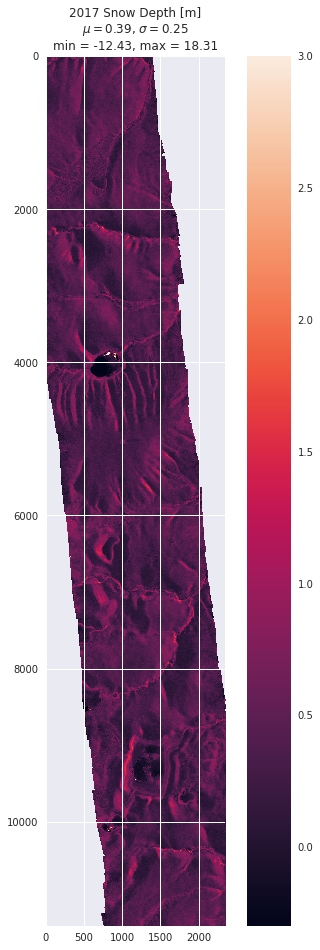

In [7]:
# Create the difference (snow depth) map

delta = new_2017_arr - dem_src.read(1)
mu = np.nanmean(delta)
sigma = np.nanstd(delta)
dmin = np.nanmin(delta)
dmax = np.nanmax(delta)


fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(111)
im = ax.imshow(delta,vmin=-0.3,vmax=3)
ax.set_title("2017 Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax))
fig.colorbar(im)

Not a bad result. It looks like the artefacts mostly have really high values on the lakes, which is pretty typical for this type of technique. If you look closely you can also see the outline of the 2012 bare earth DEM causing some higher than normal values. We can try to filter these out. Judging by the minimum, there are also some very low negative values. We can filter those as well.

/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


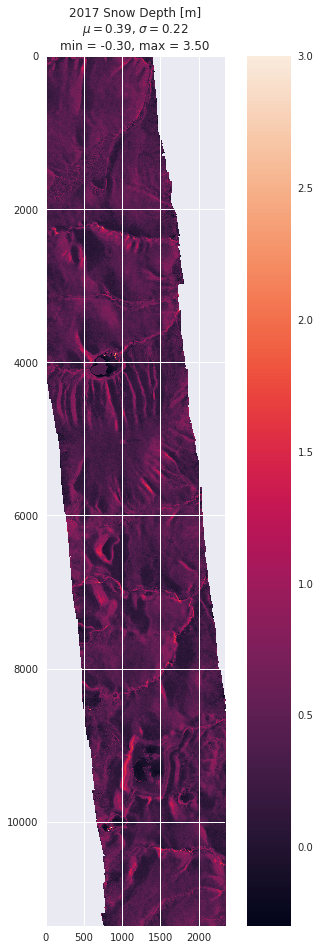

In [8]:
delta[delta > 3.5] = np.nanmean(delta)
delta[delta < -0.3] = np.nanmean(delta)
delta = delta.astype('float32')

mu = np.nanmean(delta)
sigma = np.nanstd(delta)
dmin = np.nanmin(delta)
dmax = np.nanmax(delta)


fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(111)
im = ax.imshow(delta,vmin=-0.3,vmax=3)
ax.set_title("2017 Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax))
fig.colorbar(im)

In [9]:
out_meta = src_2017.meta.copy()

out_meta.update({"height": delta.shape[0],
                 "width": delta.shape[1],
                 "transform": newaff17})

out_meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11360,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 421845.75,
       0.0, -1.0, 7673711.25),
 'width': 2340}

In [10]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/hv_version3/hv_depth_apr12_2017.tif", "w", **out_meta) as dest:
    dest.write(delta,1)

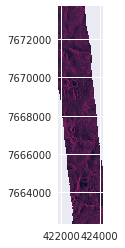

In [13]:
ddem_src = rasterio.open("/home/cparr/surfaces/depth_ddems/hv_version3/hv_depth_apr12_2017.tif")
show(ddem_src)

In [17]:
# Watertrack Validation

with fiona.open("/home/cparr/probes/hv/hv_watertracks_04142017_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
watertrack_errors = []
watertrack_sfm = []
watertrack_probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    watertrack_errors.append(probe_sfm_diff)
    watertrack_sfm.append(sfm_depth)
    watertrack_probe.append(probe_depth)
    
watertrack_sfm = np.array(watertrack_sfm)
watertrack_probe = np.array(watertrack_probe)
watertrack_errors = np.array(watertrack_errors)

# Centerline validation

with fiona.open("/home/cparr/probes/hv/hv_line_04142017_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
line_errors = []
line_sfm = []
line_probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    line_errors.append(probe_sfm_diff)
    line_sfm.append(sfm_depth)
    line_probe.append(probe_depth)
    
line_sfm = np.array(line_sfm)
line_probe = np.array(line_probe)
line_errors = np.array(line_errors)

# Lake Errors

with fiona.open("/home/cparr/probes/hv/hv_kidneylake_04152017_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
lake_errors = []
lake_sfm = []
lake_probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    lake_errors.append(probe_sfm_diff)
    lake_sfm.append(sfm_depth)
    lake_probe.append(probe_depth)
    
lake_sfm = np.array(lake_sfm)
lake_probe = np.array(lake_probe)
lake_errors = np.array(lake_errors)

# Streambank Errors

with fiona.open("/home/cparr/probes/hv/hv_streambank_04152017_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
stream_errors = []
stream_sfm = []
stream_probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    stream_errors.append(probe_sfm_diff)
    stream_sfm.append(sfm_depth)
    stream_probe.append(probe_depth)
    
stream_sfm = np.array(stream_sfm)
stream_probe = np.array(stream_probe)
stream_errors = np.array(stream_errors)

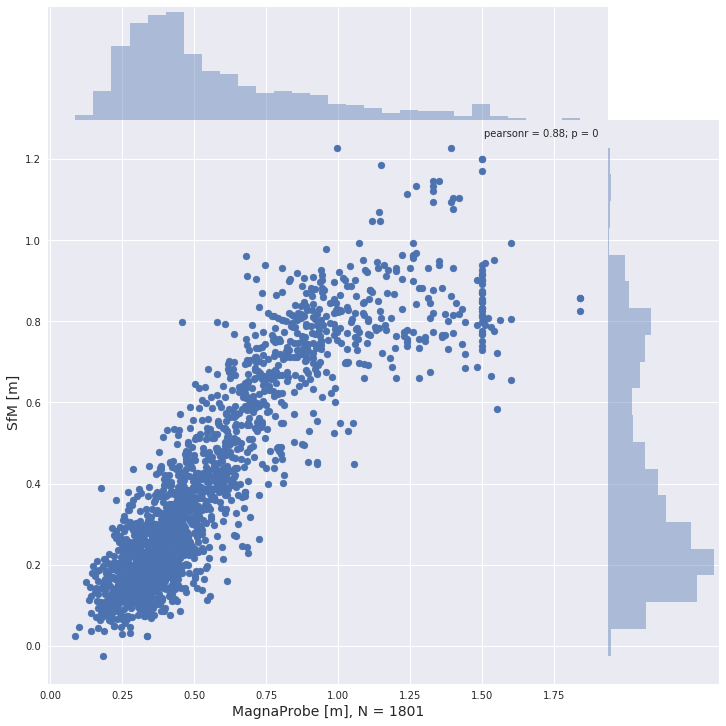

In [19]:
ax = (sns.jointplot(x=watertrack_probe, y=watertrack_sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(watertrack_probe.size), "SfM [m]", fontsize=14))

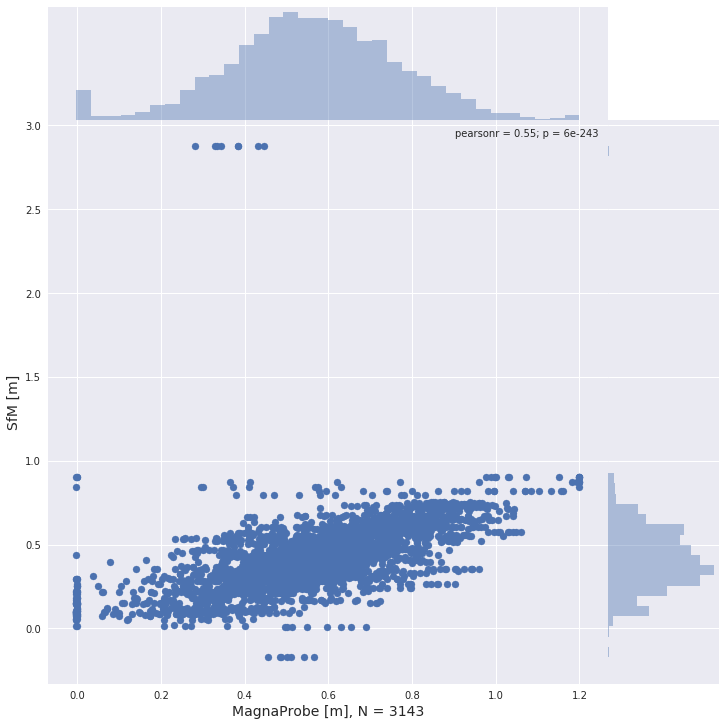

In [20]:
ax = (sns.jointplot(x=line_probe, y=line_sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(line_probe.size), "SfM [m]", fontsize=14))

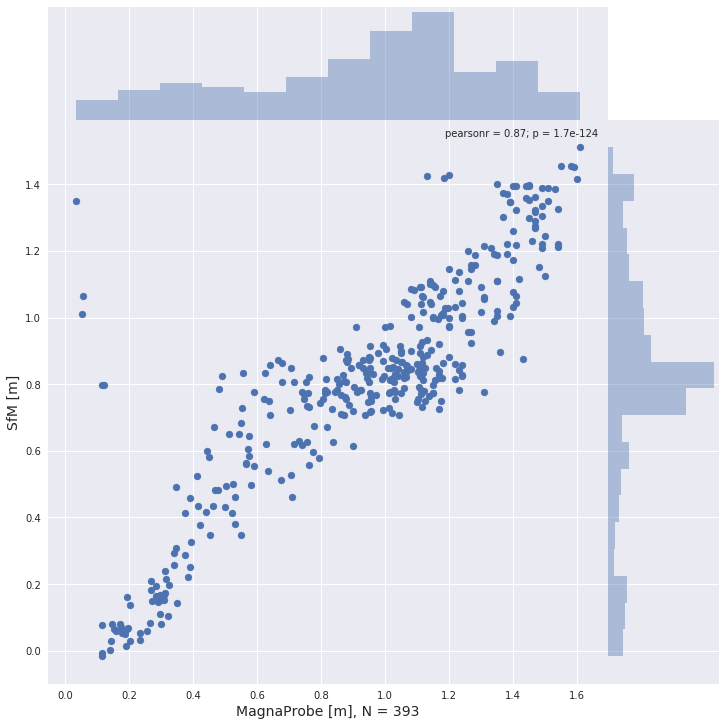

In [21]:
ax = (sns.jointplot(x=lake_probe, y=lake_sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(lake_probe.size), "SfM [m]", fontsize=14))

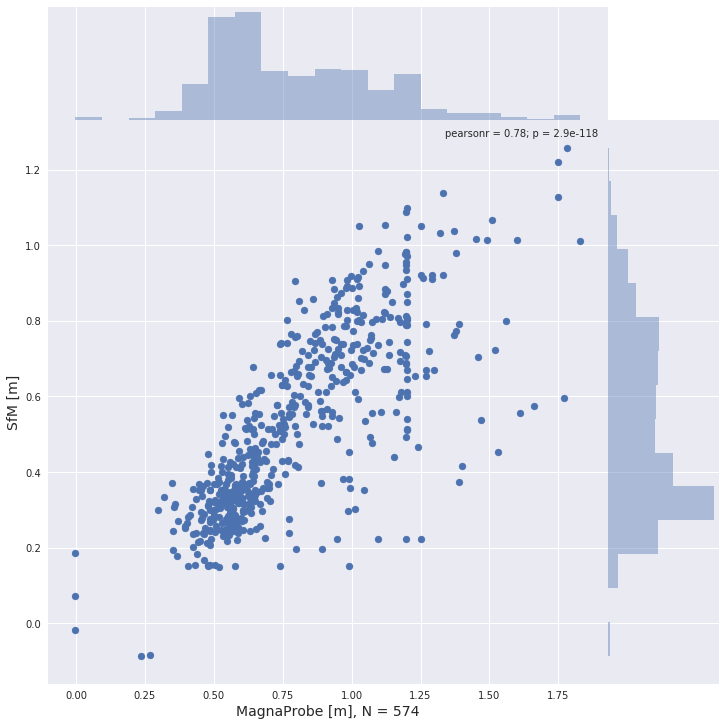

In [22]:
ax = (sns.jointplot(x=stream_probe, y=stream_sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(stream_probe.size), "SfM [m]", fontsize=14))

In [23]:
def error_check(errs):
    
    mu = np.nanmean(errs)
    sigma = np.nanstd(errs)
    dmin = np.nanmin(errs)
    dmax = np.nanmax(errs)

    plt.figure(figsize=(16,10))
    ax = sns.distplot(errs, hist=True)
    ax.set_title('Probe Depth - SfM Depth Error [m]' +'\n'+
                 "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
                 "min = %.2f, max = %.2f" %(dmin,dmax), fontsize=20)

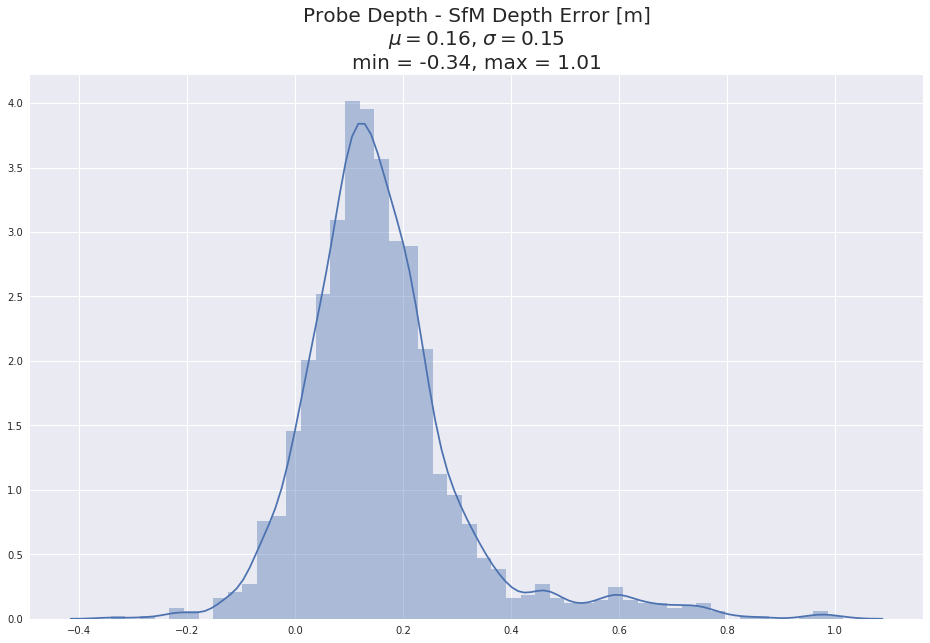

In [24]:
error_check(watertrack_errors)

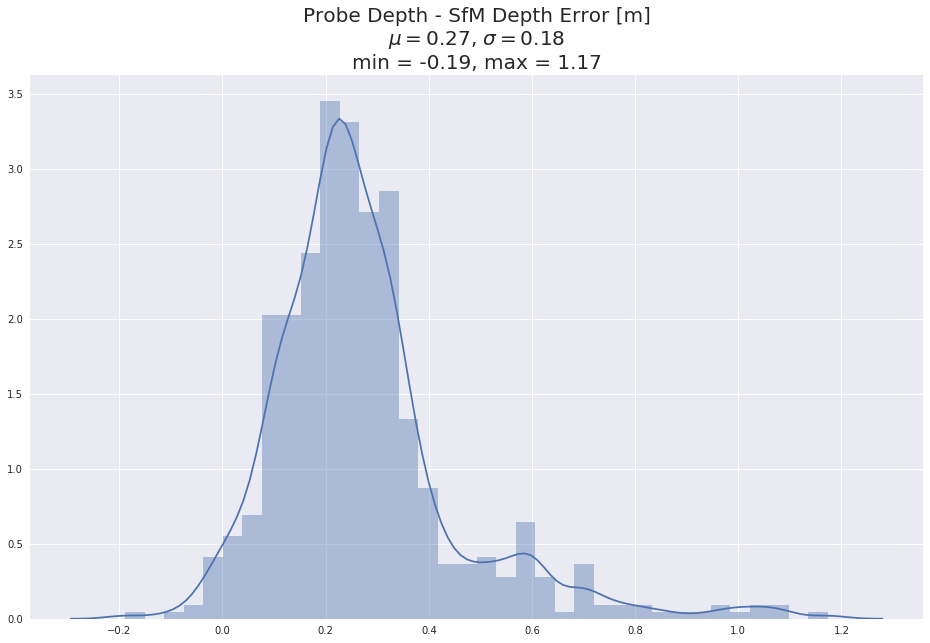

In [25]:
error_check(stream_errors)

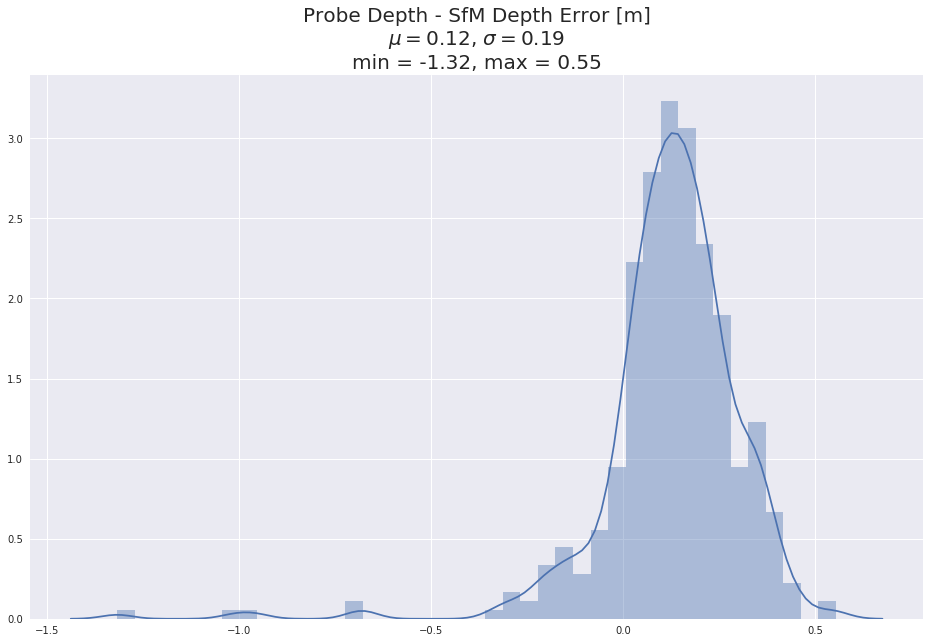

In [26]:
error_check(lake_errors)

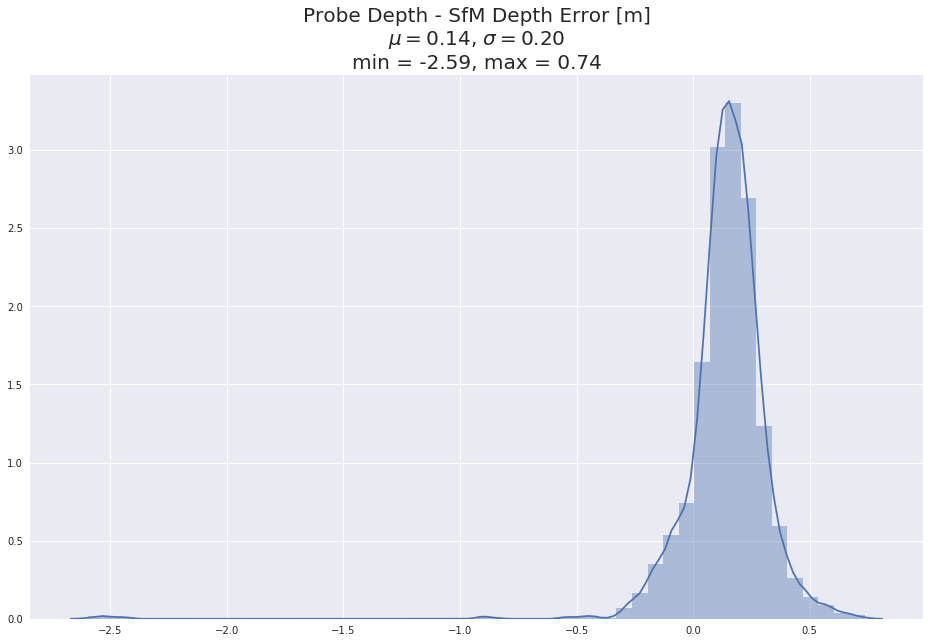

In [27]:
error_check(line_errors)

In [31]:
all_errs = np.hstack([stream_errors, lake_errors, line_errors, watertrack_errors])
all_errs.shape

(5911,)

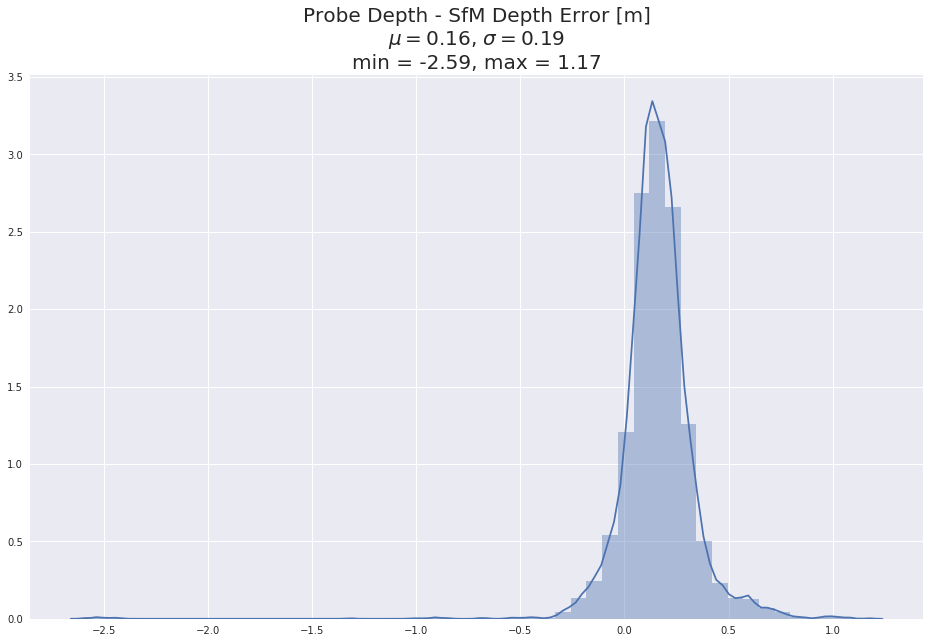

In [32]:
error_check(all_errs)

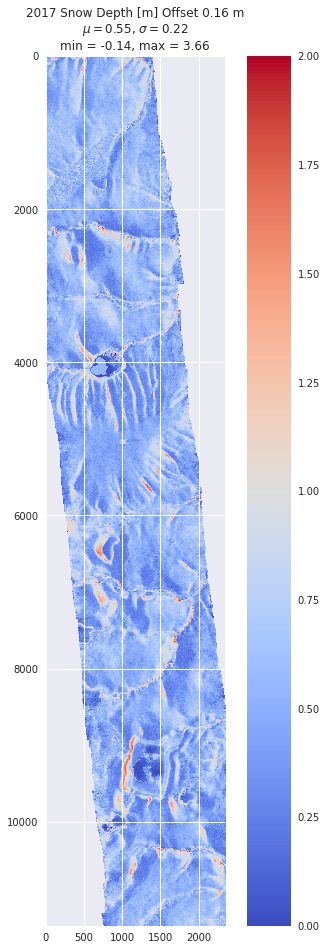

In [33]:
depth_offset = ddem_src.read(1) + 0.16
mu = np.nanmean(depth_offset)
sigma = np.nanstd(depth_offset)
dmin = np.nanmin(depth_offset)
dmax = np.nanmax(depth_offset)


fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(111)
im = ax.imshow(depth_offset,vmin=0, vmax=2, cmap='coolwarm')
ax.set_title("2017 Snow Depth [m] Offset 0.16 m" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax))
fig.colorbar(im)

In [34]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/hv_version3/hv_depth_apr12_2017_016m_offset.tif", "w", **out_meta) as dest:
    dest.write(depth_offset,1)